# H&alpha; Emitter Luminosity Function

Initiate notebook.

In [1]:
from collections import OrderedDict
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.cosmology import Planck15
from mpl_toolkits import mplot3d

from conf import PATH
from horizonground.lumfunc_modeller import (
    LumFuncModeller,
    alpha_emitter_schechter_model,
)

%matplotlib notebook

Define parameter ranges.

In [2]:
REDSHIFT_RANGE = 0., 3.
LOG10_LUMINOSITY_RANGE = 38.8, 43.8
DENSITY_RANGE = pow(10, -5.9), pow(10, -1.1)

## Luminosity function data

Determine redshift bins.

In [3]:
bin_edges = np.array([0., 0.3, 0.6, 0.9, 1.3, 1.7, 2.3])

redshift_bins = OrderedDict(
    zip(
        map(
            lambda ends: r"${} < z < {}$".format(*ends),
            zip(bin_edges[:-1], bin_edges[1:])
        ),
        (bin_edges[:-1] + bin_edges[1:])/2
    )
)

## Luminosity function model

Specify luminosity function model.

In [4]:
modeller = LumFuncModeller.from_parameters_file(
    parameter_file=PATH/"external"/"Schechter_model_fits.txt",
    lumfunc_model=alpha_emitter_schechter_model,
    brightness_variable='luminosity',
    threshold_value=3e-16,
    threshold_variable='flux',
    cosmology=Planck15,
    base10_log=False
)

luminosity_function_model = modeller.luminosity_function

Visualise luminosity function surface.

Text(0.5, 0, '$\\Phi(\\lg{L},z)$ [$\\textrm{Mpc}^{-3}$]')

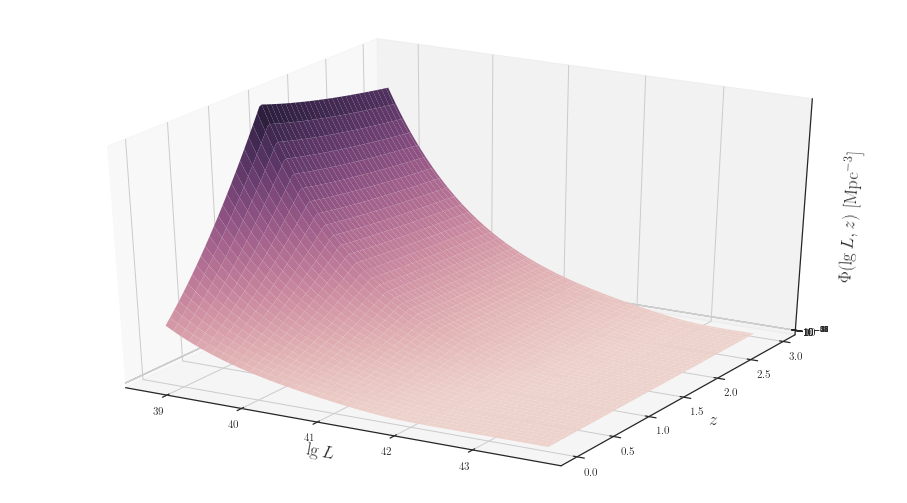

In [5]:
NUM_MESH = 100

luminosities = np.linspace(*LOG10_LUMINOSITY_RANGE, num=NUM_MESH, endpoint=False)
redshifts = np.linspace(*REDSHIFT_RANGE, num=NUM_MESH, endpoint=False)
L, z = np.meshgrid(luminosities, redshifts)
Phi = luminosity_function_model(L, z)

fig = plt.figure("Luminosity function surface", figsize=(16, 9))
ax = plt.axes(projection='3d')

ax.plot_surface(
    L, z, Phi,
    cmap=sns.cubehelix_palette(as_cmap=True), edgecolor='none'
)

ax.set_xlabel(r"$\lg{L}$", fontsize=18)
ax.set_ylabel(r"$z$", fontsize=18)

ax.set_zscale('log')
ax.set_zlabel(r"$\Phi(\lg{L},z)$ [$\textrm{Mpc}^{-3}$]", fontsize=18)

## H&alpha; luminosity function results

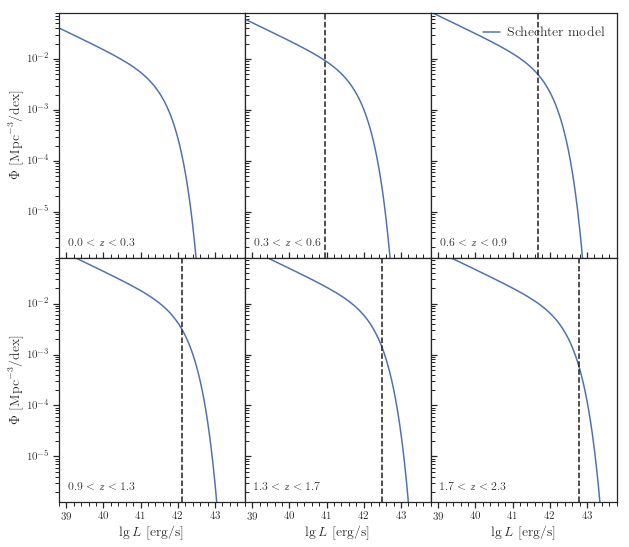

In [6]:
NUM_INTERVALS = 100

NUM_ROW, NUM_COL = 2, 3
ROW_SPAN, COL_SPAN = 4, 4

LEGEND_SETTINGS = dict(
    loc='upper right',
    handlelength=1.2, 
    handletextpad=0.5,
    fontsize=14,
)

lgL = np.linspace(*LOG10_LUMINOSITY_RANGE, num=NUM_INTERVALS+1)

plt.figure("H-alpha Luminosity Function", figsize=(10, 9))
for bin_idx, (bin_label, z) in enumerate(redshift_bins.items()):
    
    row_idx, col_idx = bin_idx // NUM_COL, bin_idx % NUM_COL
    
    ax = plt.subplot2grid(
        (NUM_ROW * ROW_SPAN, NUM_COL * COL_SPAN), 
        (row_idx * ROW_SPAN, col_idx * COL_SPAN), 
        rowspan=ROW_SPAN, colspan=COL_SPAN
    )
    
    if bin_idx == 0:
        plt.plot(lgL, luminosity_function_model(lgL, z))
    else:
        plt.plot(
            lgL, luminosity_function_model(lgL, z),
            label='Schechter model'
        )
        plt.axvline(
            modeller.brightness_threshold(bin_edges[bin_idx]), 
            c='k', ls='--'
        ) 
        
    if bin_idx == 2: 
        plt.legend(**LEGEND_SETTINGS)
    
    plt.xscale('linear')
    plt.xlim(*LOG10_LUMINOSITY_RANGE)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1.))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))
    if row_idx + 1 < NUM_ROW:
        plt.tick_params(
            axis='x', which='both', direction='in', 
            labelbottom=False, labelsize=2
        )
    else:
        plt.xlabel(r"$\lg{L}$ [erg/s]", fontsize=14)
        
    plt.yscale('log')    
    plt.ylim(*DENSITY_RANGE)
    
    if col_idx > 0:
        plt.tick_params(
            axis='y', which='both', direction='in',
            labelleft=False, labelsize=2
        )
    else:
        plt.ylabel(r"$\Phi$ [$\textrm{Mpc}^{-3}$/dex]", fontsize=14)
    
    plt.title(bin_label, loc='left', position=(0.05, 0.025))

plt.subplots_adjust(hspace=0, wspace=0)